# Fine-movement characterization

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from datetime import datetime
from scipy.interpolate import interp1d

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import umap

from one.api import ONE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
# from plotting_functions import bins_per_trial_phase, broader_label
from data_processing import process_quiescence, interpolate
from wheel_functions import wheel_trial_epoch
one = ONE(base_url='https://alyx.internationalbrainlab.org')

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:1577: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


## Load data

In [5]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)
session_all = pickle.load(open('last_3_training_2024-04-23', 'rb'))

In [6]:
threshold = 0.2 # Need to check if this makes sense
min_period = 400 # This is to match the minimum length of quiescence periods
bin_size = 0.05

# Save data of all sessions for latter
processes_quiescence_all = defaultdict(list)
perf_idx = pd.DataFrame(columns=['performance_easy', 'idx'])

# Loop through animals
mouse_names = list(session_all.keys())
for m, mouse_name in enumerate(mouse_names[0:1]):
    processes_quiescence_all[mouse_name] = {}

    # Find data of interest
    mouse_data = session_all[mouse_name]
    mouse_session_num = np.max(mouse_data['training_day'])
    use_data = mouse_data.loc[mouse_data['training_day'] >= mouse_session_num]

    # Loop through sessions
    mouse_sessions = use_data['session'].unique()
    for s, session in enumerate(mouse_sessions):
        
        session_trials = use_data.loc[use_data['session']==session]
        session_trials['index'] = np.arange(0, len(session_trials))
        
        df = wheel_trial_epoch(one, session_trials, session, bin_size, threshold, min_period).dropna()  
    #     df = df[['trial', 'wheel', 'movement', 'trial_epoch', 'feedback',
    #    'next_feedback', 'signed_contrast', 'response', 'reaction', 'choice',
    #    'probabilityLeft']].drop_duplicates()
    
        processed_quiescence = process_quiescence(df)

        # Save
        processes_quiescence_all[mouse_name][session] = processed_quiescence
        
        # Save performance also
        perf_mouse = pd.DataFrame(columns=['performance_easy', 'idx'], index=range(1))
        perf_mouse['idx'] = session
        perf_mouse['performance_easy'] = np.nanmean(session_trials['correct_easy'])
        
        # Save performance results
        if s == 0:
            perf_idx = perf_mouse
        else:
            perf_idx = perf_idx.append(perf_mouse)


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/data_processing.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['movement_duration'][1:] = np.diff(new_df['movement_onset'])


63
79
258
289
333
364
390
424
462
516
710
944
983


### Color code by trial epoch

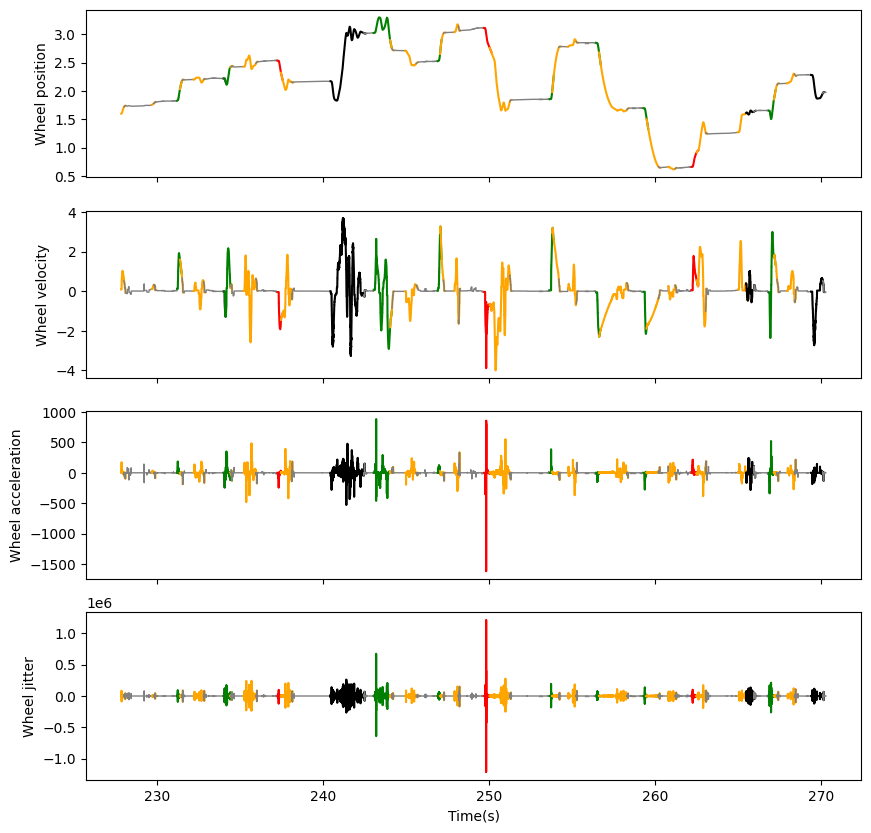

In [33]:
movements = processed_quiescence['movement_onset'][500:600].reset_index()
trial_epochs = ['trial_start', 'quiescence', 'stim_on', 'movement', 'post_choice']
colors_to_use_correct = ['black', 'purple', 'blue', 'green', 'orange']
colors_to_use_incorrect = ['black', 'purple', 'blue', 'red', 'orange']

# Plot wheel position and derivatives
metrics = ['wheel_pos', 'wheel_vel', 'wheel_acc', 'wheel_jit']
metric_labels = ['Wheel position', 'Wheel velocity', 'Wheel acceleration', 'Wheel jitter']

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.gradient(new_df['wheel_pos'], dt)
new_df['wheel_acc'] = np.gradient(new_df['wheel_vel'], dt)
new_df['wheel_jit'] = np.gradient(new_df['wheel_acc'], dt)

fig, axs = plt.subplots(nrows=len(metrics), ncols=1, sharex=True, sharey=False, figsize=[10, 10])

for me, metric in enumerate(metrics):
    
    for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
        movement_init = movement_onset
        movement_end = movements['movement_onset'][m+1]
        movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
        next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
        movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
        movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), metric]

        # Plot
        feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
        trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
        if feedback == 1.:
            colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        else:
            colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        
        if movement_bool == 1.0:
            axs[me].plot(movement_time, movement_wheel, color=colors, label=trial_epoch)
        else:
            axs[me].plot(movement_time, movement_wheel, color='grey', linewidth=1)

    axs[len(metrics)-1].set_xlabel('Time(s)')
    axs[me].set_ylabel(metric_labels[me])
    # axs[len(metrics)-1].set_xlim([55, 105])
    # axs[me].set_ylim([-.5, 2.2])
    

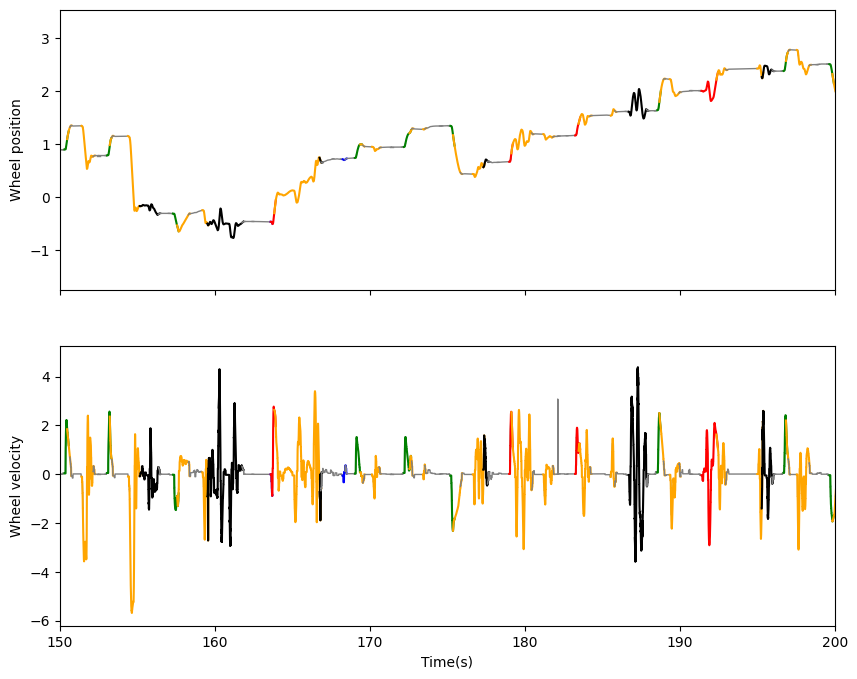

In [85]:
movements = processed_quiescence['movement_onset'][000:600].reset_index()
trial_epochs = ['trial_start', 'quiescence', 'stim_on', 'movement', 'post_choice']
colors_to_use_correct = ['black', 'purple', 'blue', 'green', 'orange']
colors_to_use_incorrect = ['black', 'purple', 'blue', 'red', 'orange']

# Plot wheel position and derivatives
metrics = ['wheel_pos', 'wheel_vel']
metric_labels = ['Wheel position', 'Wheel velocity']

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.gradient(new_df['wheel_pos'], dt)
new_df['wheel_acc'] = np.gradient(new_df['wheel_vel'], dt)
new_df['wheel_jit'] = np.gradient(new_df['wheel_acc'], dt)

fig, axs = plt.subplots(nrows=len(metrics), ncols=1, sharex=True, sharey=False, figsize=[10, 8])

for me, metric in enumerate(metrics):
    
    for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
        movement_init = movement_onset
        movement_end = movements['movement_onset'][m+1]
        movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
        next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
        movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
        movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), metric]

        # Plot
        feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
        trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
        if feedback == 1.:
            colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        else:
            colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        
        if movement_bool == 1.0:
            axs[me].plot(movement_time, movement_wheel, color=colors, label=trial_epoch)
        else:
            axs[me].plot(movement_time, movement_wheel, color='grey', linewidth=1)

    axs[len(metrics)-1].set_xlabel('Time(s)')
    axs[me].set_ylabel(metric_labels[me])
    axs[len(metrics)-1].set_xlim([150, 200])
    # axs[me].set_ylim([-.5, 2.2])
    

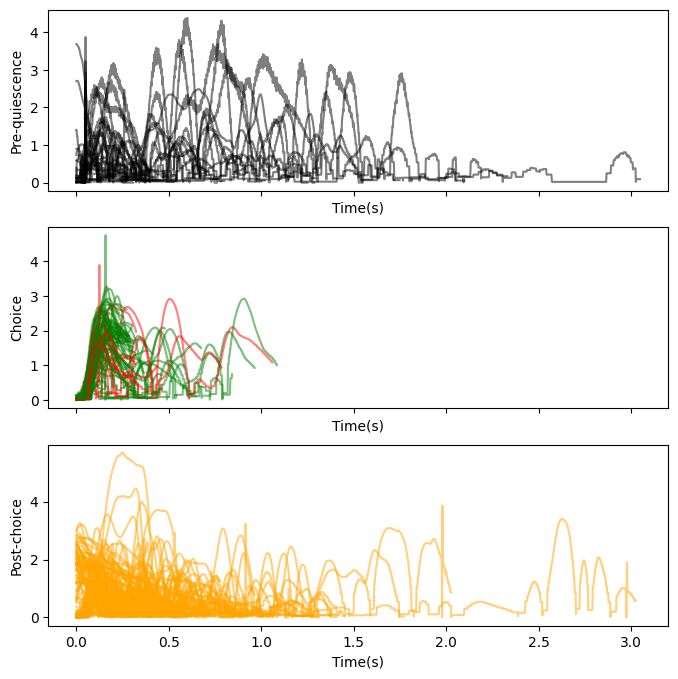

In [65]:
# movements = processed_quiescence['movement_onset'][00:600].reset_index()
reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
movements = reduced['movement_onset'][0:600].reset_index()
trial_epochs = ['trial_start', 'quiescence', 'stim_on', 'movement', 'post_choice']
colors_to_use_correct = ['black', 'purple', 'blue', 'green', 'orange']
colors_to_use_incorrect = ['black', 'purple', 'blue', 'red', 'orange']

trial_epochs_plot = ['trial_start', 'movement', 'post_choice']

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.abs(np.gradient(new_df['wheel_pos'], dt))

fig, axs = plt.subplots(nrows=len(trial_epochs_plot), ncols=1, sharex=True, sharey=False, figsize=[8, 8])

for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
    movement_init = movement_onset
    movement_end = movements['movement_onset'][m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
    movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
    movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel']

    norm_movement_time = movement_time - list(movement_time)[0]
    
    # Plot
    feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
    trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]

    if feedback == 1.:
        colors = colors_to_use_correct[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
    else:
        colors = colors_to_use_incorrect[np.where(np.array(trial_epochs)==trial_epoch)[0][0]]
        
    if movement_bool == 1.0:
        if trial_epoch == 'trial_start':
            ax = axs[0]
            ax.plot(norm_movement_time, movement_wheel, color=colors, label=trial_epoch, alpha=0.5)
        elif trial_epoch == 'movement':
            ax = axs[1]
            ax.plot(norm_movement_time, movement_wheel, color=colors, label=trial_epoch, alpha=0.5)
        elif trial_epoch == 'post_choice':
            ax = axs[2]
            ax.plot(norm_movement_time, movement_wheel, color=colors, label=trial_epoch, alpha=0.5)
    
    ax.set_xlabel('Time(s)')
    axs[0].set_ylabel('Pre-quiescence')
    axs[1].set_ylabel('Choice')
    axs[2].set_ylabel('Post-choice')
    # axs[len(metrics)-1].set_xlim([55, 105])
    # axs[me].set_ylim([-.5, 2.2])

In [15]:
processed_quiescence

,index,trial,trial_epoch,feedback,next_feedback,signed_contrast,movement,response,reaction,choice,probabilityLeft,movement_onset,epoch_onset,movement_duration,quiesc_length,time_to_quiesc,time_to_quiesc_2,pre_quiesc_move_duration,pre_quiesc_move_count
0,2377,0,trial_start,1.0,1.0,-0.9375,0.0,0.1709,0.031238,1.0,0.5,0.000638,0.000638,NaN,0.697,1.78,0.0,0.12,1
1,4177,0,trial_start,1.0,1.0,-0.9375,1.0,0.1709,0.031238,1.0,0.5,1.800638,0.000638,1.800,0.697,1.78,0.0,0.12,1
2,5327,0,trial_start,1.0,1.0,-0.9375,0.0,0.1709,0.031238,1.0,0.5,2.950638,0.000638,1.150,0.697,1.78,0.0,0.12,1
3,6727,0,trial_start,1.0,1.0,-0.9375,1.0,0.1709,0.031238,1.0,0.5,4.350638,0.000638,1.400,0.697,1.78,0.0,0.12,1
4,7527,0,trial_start,1.0,1.0,-0.9375,0.0,0.1709,0.031238,1.0,0.5,5.150638,0.000638,0.800,0.697,1.78,0.0,0.12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8682,4511889,1030,movement,1.0,1.0,0.9375,0.0,1.1552,0.790539,1.0,0.5,4509.512638,4509.512638,0.821,NaN,NaN,NaN,NaN,NaN
8683,4511977,1030,movement,1.0,1.0,0.9375,1.0,1.1552,0.790539,1.0,0.5,4509.600638,4509.512638,0.088,NaN,NaN,NaN,NaN,NaN
8684,4512254,1030,post_choice,1.0,1.0,0.9375,1.0,1.1552,0.790539,1.0,0.5,4509.877638,4509.877638,0.277,NaN,NaN,NaN,NaN,NaN
8685,4513127,1030,post_choice,1.0,1.0,0.9375,0.0,1.1552,0.790539,1.0,0.5,4510.750638,4509.877638,0.873,NaN,NaN,NaN,NaN,NaN


### Average movement per trial epoch

In [75]:
len_snippet = 30

# movements = processed_quiescence['movement_onset'][150:250].reset_index()
reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
movements = reduced['movement_onset'].reset_index()

movements_norm = pd.DataFrame(columns=['time', 'wheel', 'trial_epoch', 'trial', 'movement'])

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.abs(np.gradient(new_df['wheel_pos'], dt))
# new_df['wheel_vel_abs'] = np.abs(new_df['wheel_vel'])

for m, movement_onset in enumerate(movements['movement_onset'][:-1]):
    movement_init = movement_onset
    movement_end = movements['movement_onset'][m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
    movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
    movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel']
    # movement_wheel_vel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel']
    # movement_abs_wheel_vel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel_abs']

    feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
    next_feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'next_feedback'])[0]
    choice = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'choice'])[0]
    trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
    trial = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial'])[0]

    rescaled_wheel = interpolate(movement_time, movement_wheel, len_snippet, False)
    # rescaled_wheel_vel = interpolate(movement_time, movement_wheel_vel, len_snippet, False)
    # rescaled_abs_wheel_vel = interpolate(movement_time, movement_abs_wheel_vel, len_snippet, False)
    
    movement_df = pd.DataFrame(columns=['time', 'wheel', 'trial_epoch', 'trial'], index=range(len_snippet))
    
    # Save data per movement
    movement_df['time'] = np.array(np.arange(0, len_snippet), dtype=float)
    movement_df['wheel'] = rescaled_wheel
    # movement_df['wheel_vel'] = rescaled_wheel_vel
    # movement_df['abs_wheel_vel'] = rescaled_abs_wheel_vel
    movement_df['trial_epoch'] = trial_epoch
    movement_df['trial'] = trial

    
    if m == 0:
        movements_norm = movement_df
    else:
        movements_norm = movements_norm.append(movement_df)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/3112732678.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/3112732678.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/3112732678.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/3112732678.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

In [57]:
len_snippet = 30

# movements = processed_quiescence['movement_onset'][150:250].reset_index()
reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
movements = reduced['movement_onset'].reset_index()

movements_norm = pd.DataFrame(columns=['time', 'wheel', 'wheel_vel', 'abs_wheel_vel', 'trial_epoch', 'trial', 
                                       'choice', 'feedback', 'next_feedback'])

new_df = df.copy()
# Calculate time step (assuming uniform spacing)
dt = list(df['time'])[1] - list(df['time'])[0]
# Calculate first derivative using central differences
new_df['wheel_vel'] = np.gradient(new_df['wheel_pos'], dt)
new_df['wheel_vel_abs'] = np.abs(new_df['wheel_vel'])

for m, movement_onset in enumerate(movements['movement_onset'][:50]):
    movement_init = movement_onset
    movement_end = movements['movement_onset'][m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_end, 'movement'])[0]
    movement_time = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'time']
    movement_wheel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_pos']
    movement_wheel_vel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel']
    movement_abs_wheel_vel = new_df.loc[(new_df['time']>movement_init-.05) & (new_df['time']<=movement_end+.05), 'wheel_vel_abs']

    feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'feedback'])[0]
    next_feedback = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'next_feedback'])[0]
    choice = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'choice'])[0]
    trial_epoch = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial_epoch'])[0]
    trial = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'trial'])[0]

    rescaled_wheel = interpolate(movement_time, movement_wheel, len_snippet, False)
    rescaled_wheel_vel = interpolate(movement_time, movement_wheel_vel, len_snippet, False)
    rescaled_abs_wheel_vel = interpolate(movement_time, movement_abs_wheel_vel, len_snippet, False)
    
    movement_df = pd.DataFrame(columns=['time', 'wheel', 'wheel_vel', 'abs_wheel_vel', 'trial_epoch', 'trial',
                                        'choice', 'feedback', 'next_feedback'], index=range(len_snippet))
    
    # Save data per movement
    movement_df['time'] = np.array(np.arange(0, len_snippet), dtype=float)
    movement_df['wheel'] = rescaled_wheel
    movement_df['wheel_vel'] = rescaled_wheel_vel
    movement_df['abs_wheel_vel'] = rescaled_abs_wheel_vel
    movement_df['trial_epoch'] = trial_epoch
    movement_df['trial'] = trial
    movement_df['choice'] = choice
    movement_df['feedback'] = feedback
    movement_df['next_feedback'] = next_feedback
    
    if m == 0:
        movements_norm = movement_df
    else:
        movements_norm = movements_norm.append(movement_df)


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/1961021802.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/1961021802.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/1961021802.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movements_norm = movements_norm.append(movement_df)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_7479/1961021802.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

In [48]:
movements_norm['wheel_vel'] = np.array(movements_norm['wheel_vel'].to_list(), dtype=float)
movements_norm['time'] = np.array(movements_norm['time'].to_list(), dtype=float)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

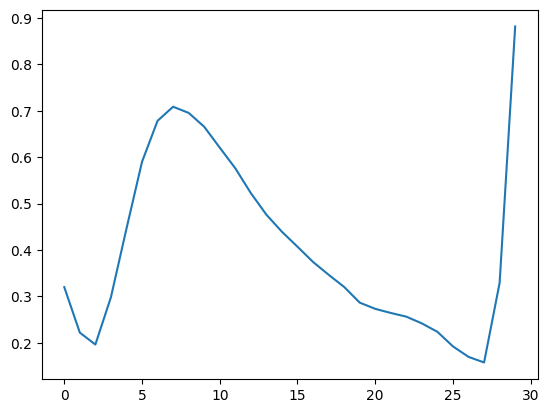

In [77]:
sns.lineplot(x='time', y='wheel',  hue='trial_epoch', data=movements_norm)

In [47]:
movements_norm

,time,wheel,wheel_vel,abs_wheel_vel,trial_epoch,trial,choice,feedback,next_feedback
0,0.0,0.009728,0.001511,0.001511,trial_start,0,1.0,1.0,1.0
1,1.0,0.009825,0.001511,0.001511,trial_start,0,1.0,1.0,1.0
2,2.0,0.009921,0.001511,0.001511,trial_start,0,1.0,1.0,1.0
3,3.0,0.010017,0.001511,0.001511,trial_start,0,1.0,1.0,1.0
4,4.0,0.010114,0.001511,0.001511,trial_start,0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
25,25.0,9.370371,0.884439,0.884439,post_choice,9,1.0,-1.0,-1.0
26,26.0,9.395015,0.652613,0.652613,post_choice,9,1.0,-1.0,-1.0
27,27.0,9.412184,0.452310,0.452310,post_choice,9,1.0,-1.0,-1.0
28,28.0,9.420895,0.182095,0.182095,post_choice,9,1.0,-1.0,-1.0


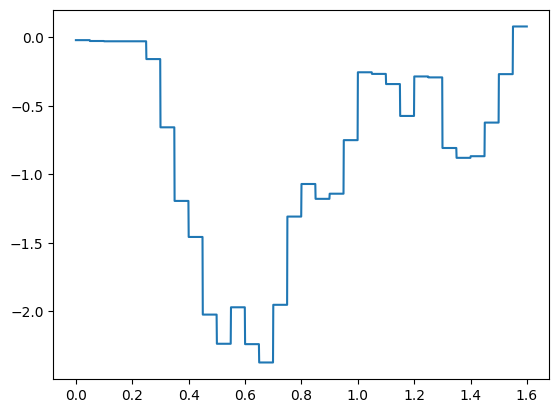

In [14]:
reduced = processed_quiescence[processed_quiescence['movement'].shift(1) != processed_quiescence['movement']].reset_index()
movements = reduced['movement_onset'][0:30]

for m, movement_onset in enumerate(movements[:1]):
    movement_init = movement_onset
    movement_end = movements[m+1]
    movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movement_init, 'movement'])[0]
    next_movement_bool = list(processed_quiescence.loc[processed_quiescence['movement_onset']==movements[m+1], 'movement'])[0]
    movement_time = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'time']
    movement_wheel = df.loc[(df['time']>movement_init-.05) & (df['time']<=movement_end+.05), 'wheel']
    if movement_bool == 1.0:
        plt.plot(movement_time, movement_wheel)
    else:
        plt.plot(movement_time, movement_wheel, color='grey', linewidth=1)

In [68]:
def interpolate(time_snippet, snippet, size, plot):
    x = np.arange(0, len(time_snippet))
    y = snippet
    f = interp1d(x, y, 'cubic')
    
    # New grid coordinates
    new_x = np.linspace(0, len(x)-1, size)  # Upscale to 6 columns

    # Interpolate values at new grid coordinates
    rescaled_array = f(new_x)
    
    if plot == True:
        # plt.plot(x, y, 'o', new_x, rescaled_array, '-')
        plt.plot(new_x, rescaled_array, '-')
        plt.plot(x, snippet)
        plt.xlabel('Time')
        plt.ylabel('Data')
        plt.show()
            
    return rescaled_array

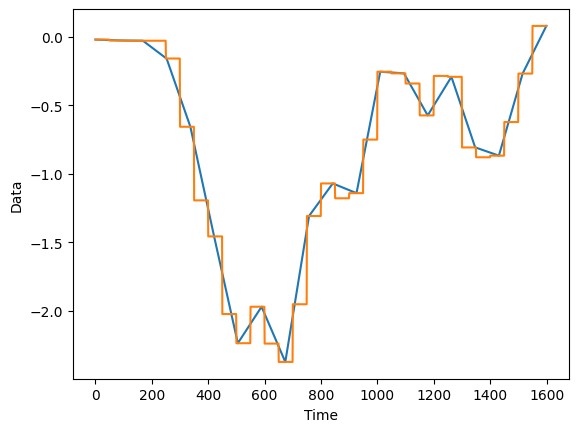

In [26]:
rescaled_array = interpolate(movement_time, movement_wheel, 20, True)

In [ ]:
# TODO
# for a single movement plot derivatives